# Foundations of Logistic Regression

In [96]:
import os

# Change the current working directory
# os.chdir('/Users/robertocerina/Desktop/CSSci Semester IV/')

In [97]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

## Exercise I: Inference and Prediction for the Homogeneous-Probability Bernoulli Model

#### a) Simulate a sample of n = 100 Bernoulli distributed outcomes, with the following probability parameter:

In [98]:
pi = np.random.uniform()
print(pi)

0.0459530986402068


#### do not look at the value of this parameters - we are going to pretend you're generating a fresh sample, and your goal is to estimate $\pi$. Imagine this $\pi$ represents the probability of any one of you saying they will vote for a right-of-centre party in the next Dutch election, and $n = 100$ suggests there are 100 of you to whom this question is being asked.

In [99]:
from scipy.stats import bernoulli
sample_size = 100
bernoulli_samples = bernoulli.rvs(pi, size=sample_size)

#### b) Plot the empirical distribution (histogram of simulations) for this set of Bernoulli outcomes

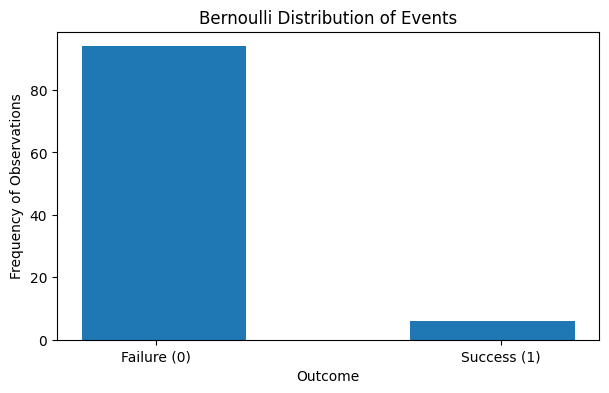

In [100]:
# Plot the Bernoulli Distribution
plt.figure(figsize=(7, 4))
plt.hist(bernoulli_samples, bins=3)
plt.title('Bernoulli Distribution of Events')
plt.xlabel('Outcome')
plt.ylabel('Frequency of Observations')
plt.xticks([0.15, 0.85], ['Failure (0)', 'Success (1)'])
plt.show()

#### c) Estimate the value of $\pi$ which is most likely to have generated this set of observations

In [101]:
# Estimate Pi Using Sample Mean
estimated_pi = np.mean(bernoulli_samples)
print(f"Estimated Pi: {estimated_pi}")

Estimated Pi: 0.06


#### d) There is uncertainty around this estimate. In theory, why might such uncertainty arise ? 

#### Answer: 

There are 2 main sources of uncertainty around the probability parameter $\pi$: 

i. *sampling uncertainty* -- if your original sample would have been slightly different, e.g. instead of getting the mean probability of our CSSsi group I'd have asked for a sample of students from a different program, I might have received a slightly different $\hat{\pi}$;

ii. *irreducible uncertainty* -- this is due to the world being simply a little `random` or `stochastic` and if I ask the same question twice I might get two different answers for no `systematic` reason. 

#### e) Represent the uncertainty around this estimate using the empricial posterior distribution evaluated at the MLE. Simulate 1000 values of $\pi$ under this distribution. Plot a histogram of the empirical posterior. 

#### Hint: there are two candidate posterior distributions you can use here -- any one will do...

Estimated Variance of Pi: 0.0005639999999999999


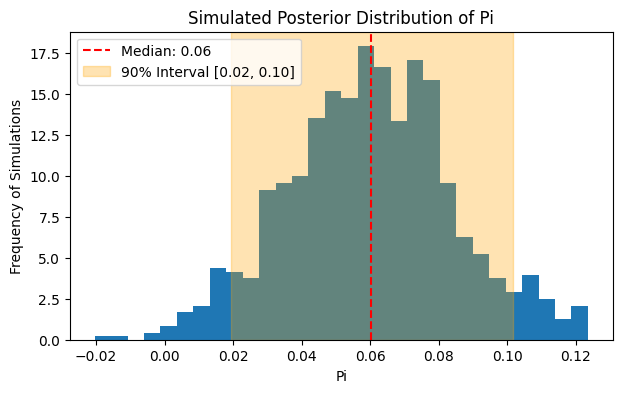

In [102]:
# Here I will use the Normal approximation of the posterior

# Calculate the estimated variance for pi
hat_var_pi = estimated_pi * (1 - estimated_pi) / sample_size
print(f"Estimated Variance of Pi: {hat_var_pi}")

# Draw simulated values from the Normal posterior
pi_sims = np.random.normal(estimated_pi,np.sqrt(hat_var_pi),1000)

# Use Monte Carlo methods to calculate summary statistics of the parameter of ineterest...
# Calculate the median and the 90% interval
median_pi = np.median(pi_sims)
lower_bound, upper_bound = np.percentile(pi_sims, [5, 95])

# Plot the simulated values
plt.figure(figsize=(7, 4))
plt.hist(pi_sims, bins=30, density=True)
plt.title('Simulated Posterior Distribution of Pi')
plt.xlabel('Pi')
plt.ylabel('Frequency of Simulations')

# Add annotations for median and 90% interval
plt.axvline(median_pi, color='r', linestyle='--', label=f'Median: {median_pi:.2f}')
plt.axvspan(lower_bound, upper_bound, color='orange', alpha=0.3, label=f'90% Interval [{lower_bound:.2f}, {upper_bound:.2f}]')
plt.legend()

plt.show()

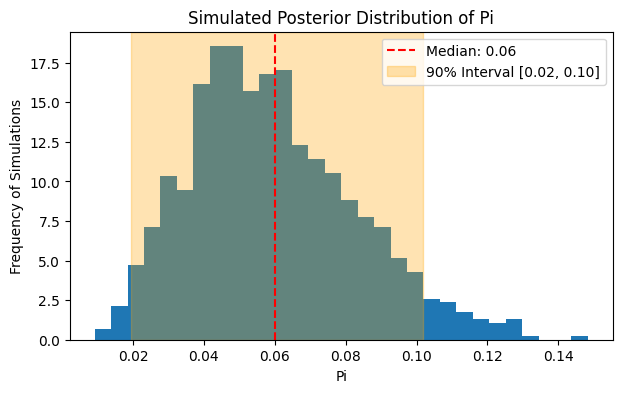

In [103]:
# Here I will use the Beta approximation of the posterior

# Calculate observed number of successes and failures
alpha = np.sum(bernoulli_samples)
beta_param = sample_size - alpha

# Define the beta distribution sampler
posterior_distribution = beta(alpha, beta_param)

# Draw simulated values from the Beta posterior
pi_sims = posterior_distribution.rvs(1000)

# Plot the simulated values
plt.figure(figsize=(7, 4))
plt.hist(pi_sims, bins=30, density=True)
plt.title('Simulated Posterior Distribution of Pi')
plt.xlabel('Pi')
plt.ylabel('Frequency of Simulations')

# Add annotations for median and 90% interval
plt.axvline(median_pi, color='r', linestyle='--', label=f'Median: {median_pi:.2f}')
plt.axvspan(lower_bound, upper_bound, color='orange', alpha=0.3, label=f'90% Interval [{lower_bound:.2f}, {upper_bound:.2f}]')
plt.legend()

plt.show()

#### f) For each simulated value of $\pi$, generate a new sample of observations `y`. Plot the histogram of these newly generated samples. If you were to observe a new individual from this population, would you classify them as a right-of-centre voter ? and why ?  

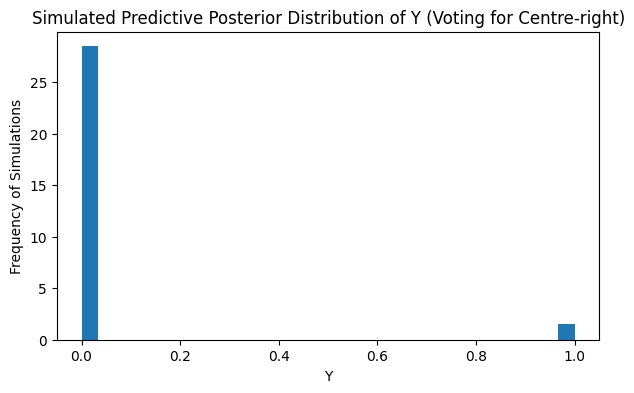

In [104]:
# Here we use the posterior predictive distribution of y to generate new samples for a hypothetical unobserved student

# Generate new values of y corresponding to each value of pi_sims
post_pred_sims = []
for pi in pi_sims:
    y = bernoulli.rvs(pi)
    post_pred_sims.append(y)

# Convert the list to a numpy array
post_pred_sims = np.array(post_pred_sims)

# Plot the simulated values
plt.figure(figsize=(7, 4))
plt.hist(post_pred_sims, bins=30, density=True)
plt.title('Simulated Predictive Posterior Distribution of Y (Voting for Centre-right)')
plt.xlabel('Y')
plt.ylabel('Frequency of Simulations')

plt.show()

## Exercise II: Logistic Regression, Simulation-Based Inference & Prediction

#### a) Load the ANES 2020 sample, and check the number of respondents. (Hint: it's a `stata` file)

In [105]:
# Load ANES data
df = pd.read_stata('4.National_Election_Studies/American National Election Study/2020/anes_timeseries_2020_stata_20210324.dta')

# Check dataset size
print(df.shape)

FileNotFoundError: [Errno 2] No such file or directory: '4.National_Election_Studies/American National Election Study/2020/anes_timeseries_2020_stata_20210324.dta'

#### b) Subset the dataset to include only people who `intend to vote for president` in the pre-election study (Hint: in the codebook look for variable `V201032`)

In [ ]:
# Focus on voters only 
# Turnout Intention variable: V201032
print(df['V201032'].value_counts())

# Keep only observations from respondents who say they indend to vote
df = df[df['V201032'] == '1. Yes']

# Check how many rows you dropped
print(df.shape)

V201032
1. Yes              7272
2. No                570
-1. Inapplicable     415
-9. Refused           13
-8. Don't know        10
Name: count, dtype: int64
(7272, 1381)


#### c) Define the outcome of interest as 1 if the voter will vote for the Republicans, 0 otherwise. (Hint: in the codebook look for variable `V201033` )

In [ ]:
print(df['V201033'].value_counts())

V201033
1. Joe Biden                    3759
2. Donald Trump                 3016
5. Other candidate {SPECIFY}     175
3. Jo Jorgensen                  133
-9. Refused                      101
4. Howie Hawkins                  55
-8. Don't know                    33
-1. Inapplicable                   0
Name: count, dtype: int64


In [ ]:
Y = df['V201033'].apply(lambda x: 1 if x == '2. Donald Trump' else 0)

#### d) Create a design matrix including age, sex, education or anything else you think would be a good predictor of the vote. # Turn these features into a numeric matrix so we can use them to fit the model. 

#### Note: Remember the `dummy trap`...if you have a categorical variable with `m` possible values, you can only have `m-1` such variables be dummies in your model, due to perfect multi-collinearity...

In [ ]:
# Age: 
age_num = pd.to_numeric(df['V201507x'], errors='coerce')

# College Degree or Higher:
college_edu = df['V201510'].apply(lambda x: 1 if x in ["6. Bachelor's degree (e.g. BA, AB, BS)",
                                                       "7. Master's degree (e.g. MA, MS, MEng, MEd, MSW, MBA)",
                                                       "4. Associate degree in college - occupational/vocational",
                                                       "5. Associate degree in college - academic"] else 0)

# Sex:
male_binary = df['V201600'].apply(lambda x: 1 if x == '1. Male' else 0)

# Ethnicity: 
white_binary = df['V201549x'].apply(lambda x: 1 if x == '1. White, non-Hispanic' else 0)

# Create design matrix 
X = pd.DataFrame({
    'Age': age_num,
    'College_Degree_or_Higher': college_edu,
    'Sex_Male': male_binary,
    'Ethnicity_White': white_binary
})


# Display the first few rows of the DataFrame
print(X.head())

    Age  College_Degree_or_Higher  Sex_Male  Ethnicity_White
0  46.0                         1         1                0
1  37.0                         0         0                0
2  40.0                         0         0                1
3  41.0                         1         1                0
4  72.0                         0         1                0


#### e) Explore the correlation matrix between the covariates and the outcome. Which variables are most linearly related ? Does the direction of the correlation make sense ? Which covariates are most related to the outcome ? 

#### Hint: remember to drop missing values... for both X and Y...

In [ ]:
YX = np.hstack((np.array(Y)[:, np.newaxis], X))
YX = YX[~np.any(np.isnan(YX), axis=1)]
# Examine the correlation between covariates and outcome (outcome is the first column)
# Can you identify some `perfect multicollinearity' that could hinder the estimation ? 
np.corrcoef(YX.T)

array([[ 1.        ,  0.0998711 , -0.06906375,  0.07301269,  0.22131516],
       [ 0.0998711 ,  1.        , -0.03289812,  0.0180753 ,  0.16486809],
       [-0.06906375, -0.03289812,  1.        , -0.02851965,  0.06376817],
       [ 0.07301269,  0.0180753 , -0.02851965,  1.        ,  0.02777518],
       [ 0.22131516,  0.16486809,  0.06376817,  0.02777518,  1.        ]])

#### f) Fit the logistic regression model using statsmodels. Make sure the estimation procedure has converged.
#### If not, examine the errors and figure out why it's not. Remember to drop the NAs.

In [ ]:
Y = YX[:,0]
X = pd.DataFrame(YX[:,1:], columns=['Age', 'College_Degree', 'Sex_Male', 'Ethnicity_White'])  # Design matrix with column names
X_with_intercept = sm.add_constant(X)

model = sm.Logit(Y, X_with_intercept).fit()

Optimization terminated successfully.
         Current function value: 0.642839
         Iterations 5


#### g) Get summary of regression output.

In [ ]:
# Get summary results
summary = model.summary()
print(summary)

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6630
Model:                          Logit   Df Residuals:                     6625
Method:                           MLE   Df Model:                            4
Date:                Sun, 18 Feb 2024   Pseudo R-squ.:                 0.04954
Time:                        15:15:40   Log-Likelihood:                -4262.0
converged:                       True   LL-Null:                       -4484.2
Covariance Type:            nonrobust   LLR p-value:                 7.486e-95
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.5528      0.102    -15.252      0.000      -1.752      -1.353
Age                 0.0081      0.002      4.987      0.000       0.005       0.011
College_Degree     -0.3418      

#### h) Simulate 1000 values for for each regression coefficient, from the empirical posterior distribution. Remember this is a Multivariate normal. Use  model.cov_params() to extract the covariance matrix. 

In [ ]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

#### i) Calculate summary statistics from these simulations, along with the probability of the coefficient being > 0 . Plot the histograms for each coefficient. Comment on the statistical significance. What should you do if you wish to compare effect sizes across coefficients ?

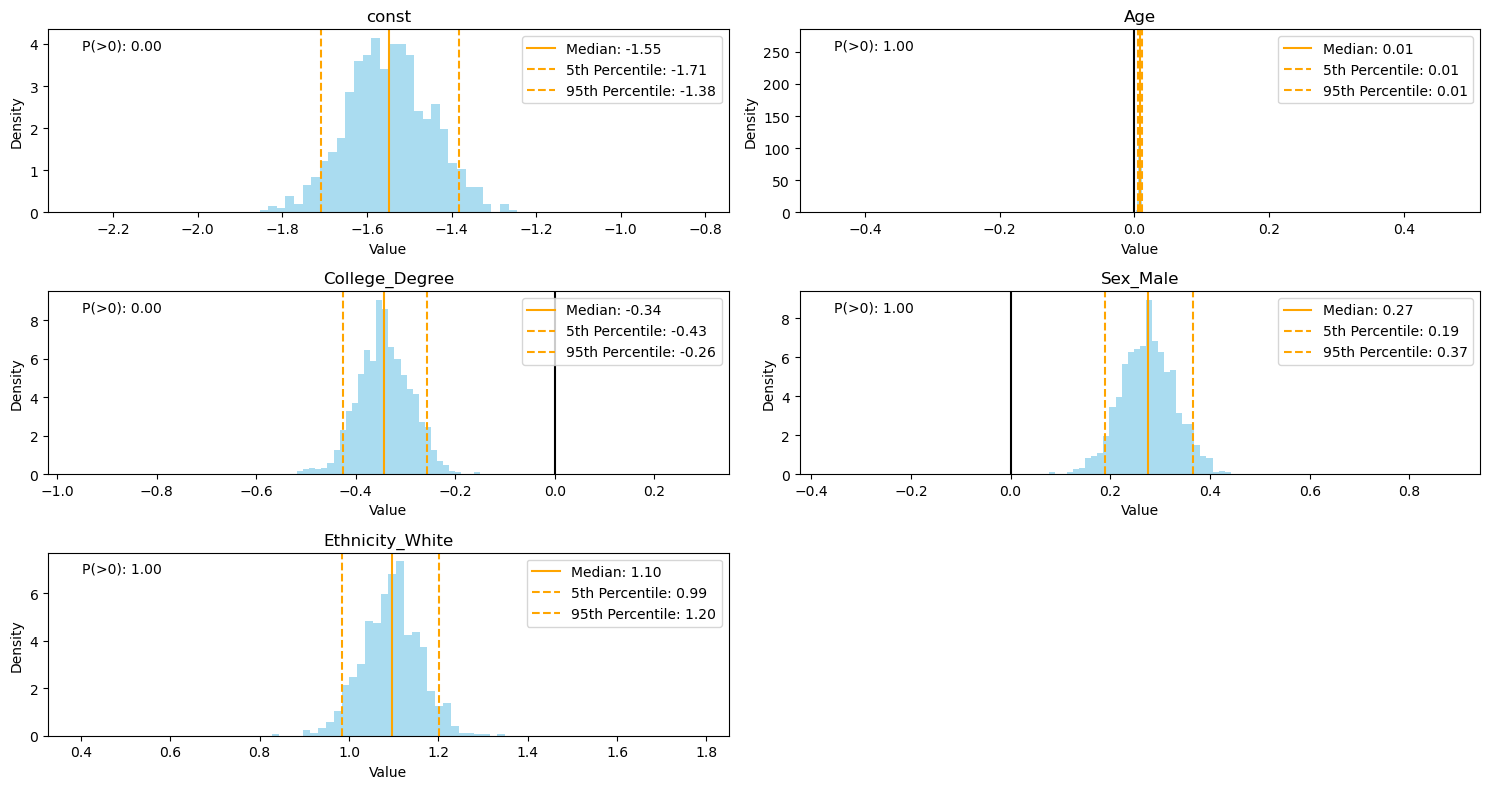

In [ ]:
# Calculate statistics for each coefficient
medians = np.median(simulated_betas, axis=0)
lower_quantiles = np.percentile(simulated_betas, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas, 95, axis=0)
prob_positive = np.mean(simulated_betas > 0, axis=0)

# Plot histograms of each coefficient
num_rows = (num_coeffs + 1) // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(num_coeffs):
    ax = axs[i]
    ax.hist(simulated_betas[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(0, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 0
    ax.text(0.05, 0.95, f'P(>0): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{X_with_intercept.columns[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 0
    ax.set_xlim(left=min(simulated_betas[:, i]) - 0.5, right=max(simulated_betas[:, i]) + 0.5)
    
# Hide empty subplot
if num_coeffs % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()


#### i) Now let's practice making predictions from this model that we learned. Below is definded the `average american voter`. For this hypothetical person, make a prediction for the probability of voting republican. Ensure to use simulations to gennerate samples of this probability,  and fully account for uncertainty. 

#### Hint: use the `logistic_sigmoid` function to turn simulations of $\mu$ into $\pi$.

In [ ]:
# Calculate the average of the sample for each predictor
average_X = X_with_intercept.mean(axis=0)

# Generate new predicted probabilities for the new observation using the simulated betas
new_predicted_probs = logistic_sigmoid(np.dot(simulated_betas, average_X))

#### l) Now generate values from the posterior predictive distirbution of the outcome Y (So for this hypothetical average voter, simulate 1000 times who they will vote for). Who does the average american voter cast their ballor for in 2020 ? 

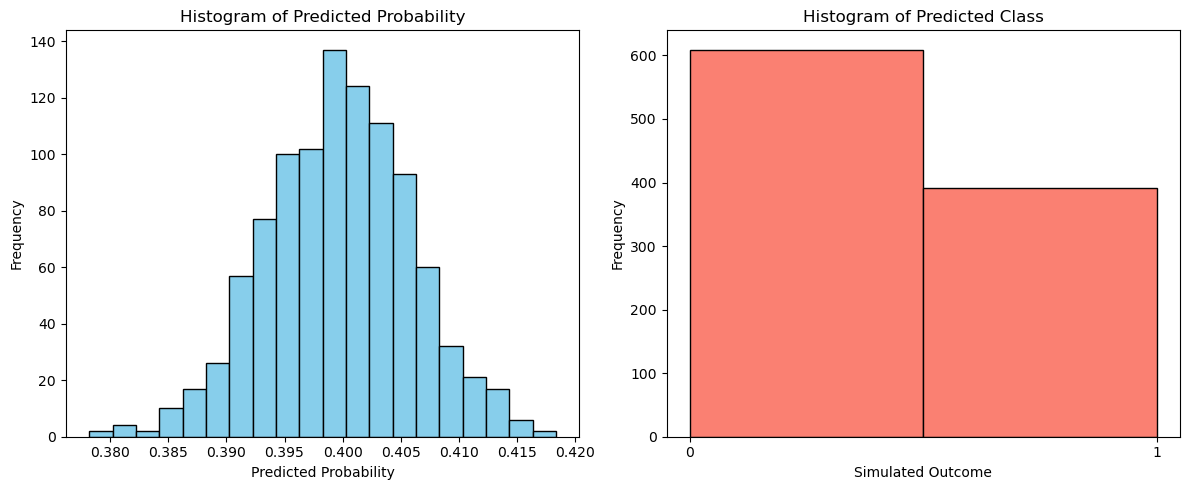

In [ ]:
# Simulate outcomes for the new observation based on the new predicted probabilities
new_simulated_outcomes = np.random.binomial(1, new_predicted_probs)

# Plotting both the new predicted probabilities and the simulated outcomes in histograms
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot for new predicted probabilities
axes[0].hist(new_predicted_probs, bins=20, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Predicted Probability')
axes[0].set_xlabel('Predicted Probability')
axes[0].set_ylabel('Frequency')

# Plot for simulated outcomes
axes[1].hist(new_simulated_outcomes, bins=2, color='salmon', edgecolor='black')
axes[1].set_title('Histogram of Predicted Class')
axes[1].set_xlabel('Simulated Outcome')
axes[1].set_ylabel('Frequency')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['0', '1'])

plt.tight_layout()
plt.show()
